# Malaria Senegal 2020 Sample Import
## Prepare Senegal 2020 samples for import into Terra.
## Generates a TSV that can be uploaded / merged into existing data tables.
## Author: Jonn Smith
## Date: 2023 12 06

Note: This assumes you already have a set of metrics XLSX files from GP.

***

# Inputs:
## Most inputs are here.  There are a few lower down where the sample name parsing regexes are.

In [331]:
data_dir = "/juffowup2/malaria/Senegal_2020_data"

gcloud_dir = "gs://broad-dsp-lrma-sr-malaria/falciparum/senegal/2020_samples"

DIR_PREFIX = "/home/jovyan/work"

out_file_prefix = "2020_Senegal_Data"

COLLECTION_SITES_TSV_FILE = f"{DIR_PREFIX}{data_dir}/2020_Collection_Sites.tsv"

dataset_name = "Broad 2020 Senegal Dataset"

tsv_for_import_output_file_name = f"2020_master_samples_to_add.tsv"
tsv_sample_path_info_file_name = "2020_master_samples_to_add.sample_id_sample_path_map.tsv"
copy_script_base_name = "2020_senegal_samples.copy_to_cloud.sh"
not_imported_samples_tsv_name = "2020_samples_not_imported.tsv"

***

In [333]:
try:
    import pylev
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install pylev
    import pylev

In [334]:
import sys
import pysam
import gzip
import os
import stat
import re
import time

import numpy as np
import pandas as pd

import datetime

from collections import defaultdict

from tqdm.notebook import tqdm

In [335]:
from sklearn.manifold import MDS
from umap import UMAP
import leidenalg

In [336]:
import matplotlib
import matplotlib.pyplot as plt

# Make big figures:
gFIG_SIZE_in = [14, 10]

# Set plotting defaults:
gPLOT_PARAMS = {
    "legend.fontsize": "x-large",
    "figure.figsize": gFIG_SIZE_in,
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large"
}
matplotlib.rcParams.update(gPLOT_PARAMS)
plt.rcParams.update(gPLOT_PARAMS)

# Some single-place definitions of sizes for plots / figures:
gFONT_SIZE_UNITS = "pt"
gTITLE_FONT_SIZE = 36
gAXIS_LABEL_FONT_SIZE = 24
gTICK_LABEL_FONT_SIZE = 16
gTEXT_FONT_SIZE = 16

# To track global figure number creation:
gFIG_NUM = 0


def fix_plot_visuals(fig,
                     titlesize=gTITLE_FONT_SIZE,
                     labelsize=gAXIS_LABEL_FONT_SIZE,
                     ticklabelsize=gTICK_LABEL_FONT_SIZE,
                     textsize=gTEXT_FONT_SIZE,
                     tight_rect=None):
    """Fix the plot elements to be appropriate sizes for a slide / presentation."""

    if not textsize:
        textsize = ticklabelsize

    for ax in fig.get_axes():

        for ticklabel in (ax.get_xticklabels()):
            ticklabel.set_fontsize(ticklabelsize)
        for ticklabel in (ax.get_yticklabels()):
            ticklabel.set_fontsize(ticklabelsize)
        for c in ax.get_children():
            if c.__class__ == matplotlib.text.Text:
                c.set_fontsize(textsize)

        ax.xaxis.get_label().set_fontsize(labelsize)
        ax.yaxis.get_label().set_fontsize(labelsize)
        ax.title.set_fontsize(titlesize)

    for c in fig.get_children():
        if c.__class__ == matplotlib.legend.Legend:
            c.prop.set_size(ticklabelsize)
            c.get_title().set_size(ticklabelsize)

    if tight_rect:
        fig.tight_layout(rect=tight_rect)
    else:
        fig.tight_layout()
    
    if fig._suptitle:
        sup_title = fig._suptitle.get_text()
        fig.suptitle(sup_title, fontsize=titlesize)
    
    # Make it so we can actually see what's happening on the plots with "dark mode":
    fig.patch.set_facecolor("white")

In [337]:
def fix_nans(df, quiet=True):
    if not quiet: print("Replacing all `nan` values with empty strings: ")
    for c in df.columns.values:
        nan_types = ("nan", float('nan'))
        has_nan = False
        num_denaned = 0
        for n in nan_types:
            if (sum(df[c] == n) > 0):
                num_denaned += sum(df[c] == n)
                df.loc[df[c] == n, c] = ""
                has_nan = True
        if has_nan and not quiet:
            print(f"\t{c}: {num_denaned}")

    if not quiet: print("Replacing numpy nan values...")
    if not quiet: print("Done.")
    return df.replace(np.nan, "")

def force_string_vals(df):
    for c in df.columns:
        df[c] = df[c].astype(str)
    return df

# Read in the Metrics xslx files

In [338]:
# Get all XLSX metrics files in the data dir:
xlsx_files = sorted([f for f in os.listdir(f"{DIR_PREFIX}/{data_dir}") if f.endswith(".xlsx") and "Metrics" in f])

In [339]:
# Read in each XLSX file:
dataframes = []
for fxlsx in xlsx_files:
    
    print(f"Reading {fxlsx}")
    
    header=1
    if 'PDO-29957' in fxlsx or 'PDO-29960' in fxlsx:
        header=0
    df = pd.read_excel(fxlsx, header=header)

    dataframes.append(df.fillna(""))

Reading PDO-29957 Metrics.xlsx
Reading PDO-29958 Metrics.xlsx
Reading PDO-29959 Metrics.xlsx
Reading PDO-29960 Metrics.xlsx
Reading PDO-29961 Metrics.xlsx
Reading PDO-29962 Metrics.xlsx
Reading PDO-29963 Metrics.xlsx


In [340]:
# Append dataframes together:
main_df = dataframes[0]
for df in dataframes[1:]:
    main_df = main_df.append(df)

# Clean any nans:
main_df.fillna("")
    
# Drop duplicates by sample:
main_df = main_df.drop_duplicates(subset=['Sample'])

In [342]:
# Write out combined metrics file:
pdo_nums = "_".join([s.replace(" Metrics.xlsx", "").replace("PDO-", "") for s in xlsx_files])
main_df.to_csv(f"{out_file_prefix}_PDOs-{pdo_nums}.combined.tsv", sep="\t", index=False)

In [343]:
main_df

,Project,Sample,PDO Sample,Individual ' ID,Plated Sample,LSIDs,Bait Set,Processing Location,Research Project Name,Initiative Name,...,Aggregated Lanes,WR ID,Latest Plated Volume,Latest Plated Concentration,BAM Path,BAM Path with version,Version,Product Goal,# Lanes in Aggregation,PF Reads
0,RP-2647.A02_SM-N463S_26915,SEN_SES_PS_188_2020,426406653,'SEN_SES_PS_188,SM-N463S,broadinstitute.org:bsp.prod.sample:N463S,,OnPrem,Volkman_Plasmodium_NEB,,...,"H2F3CDRX3/1,H2F3CDRX3/2",,,,/seq/picard_aggregation/RP-2647.A02_SM-N463S_2...,/seq/picard_aggregation/RP-2647.A02_SM-N463S_2...,1,,2,15589816
1,RP-2647.A03_SM-N463T_26915,SEN_SES_PS_111_2020,426406653,'SEN_SES_PS_111,SM-N463T,broadinstitute.org:bsp.prod.sample:N463T,,OnPrem,Volkman_Plasmodium_NEB,,...,"H2F3CDRX3/1,H2F3CDRX3/2",,,,/seq/picard_aggregation/RP-2647.A03_SM-N463T_2...,/seq/picard_aggregation/RP-2647.A03_SM-N463T_2...,1,,2,20293830
2,RP-2647.A04_SM-N33YU_26915,SM-N33YU,426406653,'Multiple,SM-N33YU,broadinstitute.org:bsp.prod.sample:N33YU,,OnPrem,Volkman_Plasmodium_NEB,,...,"H2F3CDRX3/1,H2F3CDRX3/2",,,,/seq/picard_aggregation/RP-2647.A04_SM-N33YU_2...,/seq/picard_aggregation/RP-2647.A04_SM-N33YU_2...,1,,2,19528224
3,RP-2647.A05_SM-JVCKI_26915,microbial_pos_973,426406653,'microbial_pos_973,SM-JVCKI,broadinstitute.org:bsp.prod.sample:JVCKI,,OnPrem,Volkman_Plasmodium_NEB,,...,"H2F3CDRX3/1,H2F3CDRX3/2",,,,/seq/picard_aggregation/RP-2647.A05_SM-JVCKI_2...,/seq/picard_aggregation/RP-2647.A05_SM-JVCKI_2...,1,,2,2976760
4,RP-2647.A06_SM-K5JLR_26915,microbes_negcntrl_10_06_20_257,426406653,'microbes_negcntrl_10_06_20_257,SM-K5JLR,broadinstitute.org:bsp.prod.sample:K5JLR,,OnPrem,Volkman_Plasmodium_NEB,,...,"H2F3CDRX3/1,H2F3CDRX3/2",,,,/seq/picard_aggregation/RP-2647.A06_SM-K5JLR_2...,/seq/picard_aggregation/RP-2647.A06_SM-K5JLR_2...,1,,2,3516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,RP-2647.H10_PT-3LJ9X_26920,SEN_NDO_DM2_054_2020,426406682,'SEN_NDO_DM2_054,SM-N4SJX,broadinstitute.org:bsp.prod.sample:N4SJX,,OnPrem,Volkman_Plasmodium_NEB,,...,"H2CLHDRX3/1,H2CLHDRX3/2",,,,/seq/picard_aggregation/RP-2647.H10_PT-3LJ9X_2...,/seq/picard_aggregation/RP-2647.H10_PT-3LJ9X_2...,1,,2,20856244
188,RP-2647.H11_PT-3LHHY_26921,SEN_SES_PS_198_2116,421575554,'SEN_SES_PS_198,SM-N4SMM,broadinstitute.org:bsp.prod.sample:N4SMM,,OnPrem,Volkman_Plasmodium_NEB,,...,"H2CVHDRX3/1,H2CVHDRX3/2",,,,/seq/picard_aggregation/RP-2647.H11_PT-3LHHY_2...,/seq/picard_aggregation/RP-2647.H11_PT-3LHHY_2...,1,,2,13444996
189,RP-2647.H11_PT-3LJ9Y_26920,SEN_NDO_DM3_141_2020,426406682,'SEN_NDO_DM3_141,SM-N4SJY,broadinstitute.org:bsp.prod.sample:N4SJY,,OnPrem,Volkman_Plasmodium_NEB,,...,"H2CLHDRX3/1,H2CLHDRX3/2",,,,/seq/picard_aggregation/RP-2647.H11_PT-3LJ9Y_2...,/seq/picard_aggregation/RP-2647.H11_PT-3LJ9Y_2...,1,,2,13808456
190,RP-2647.H12_PT-3LJ8L_26920,SEN_NDO_DM3_130_2020,426406682,'SEN_NDO_DM3_130,SM-N4SHH,broadinstitute.org:bsp.prod.sample:N4SHH,,OnPrem,Volkman_Plasmodium_NEB,,...,"H2CLHDRX3/1,H2CLHDRX3/2",,,,/seq/picard_aggregation/RP-2647.H12_PT-3LJ8L_2...,/seq/picard_aggregation/RP-2647.H12_PT-3LJ8L_2...,1,,2,17239094


***
# Now create mapping to new sample names:

In [344]:
# Read in the collection site info:
site_lookup_df = pd.read_table(COLLECTION_SITES_TSV_FILE, sep="\t").fillna("")
site_lookup_df

,REGION (RM),DISTRICT (DS),SITE (PS),TYPE*,CODE,ALT1,Unnamed: 6,ALT2,Latitude,Longitude,String,2019,2020,2021,2022,2023
0,KOLDA,KOLDA,BAGADADJI,SI,BAG,KLD,,KD,13.434,-13,,X,X,X,,
1,MATAM,KANEL,SINTHIOU BANAMBE,,BAM,,,,,,,,X,X,X,
2,KEDOUGOU,KEDOUGOU,BANDAFASSI,SS + PP,BAN,BN,,,12.5394,-12.3106,Kedougou_Kedougou_BandaFassi,0,X,X,X,
3,LOUGA,LINGUERE,BARKEDJI,SS,BAR,BR,,,15.276,-14.8694,Louga_Linguere_Barkedji,,X,X,,
4,ST-LOUIS,RICHARD TOLL,SUGAR COMPANY CLINIC,N,CSS,RT_CS,,CS,16.47,-15.71,,X,,,,
5,DAKAR,PIKINE,DEGGO,SS,DEG,DE,,,14.7559,-17.3961,Dakar_Pikine_Deggo,X,X,X,X,
6,TAMBACOUNDA,TAMBACOUNDA,DIALOCOTO,SI,DIA,TAM,,TA,13.315,-13.287,,X,X,X,X,
7,ST-LOUIS,RICHARD TOLL,DIAWAR,N,DWR,RT_DW,,DW,16.4614,-16.0516,,X,,,,
8,TAMBACOUNDA,BAKEL,GABOU,SS,GAB,GA,,,14.9047,-12.4564,Tamba_Bakel_Gabou,X,X,X,X,
9,ST-LOUIS,RICHARD TOLL,GALLO MALICK,N,GMK,RT_GM,,GM,16.4163,-16.111,,X,,,,


In [345]:
def is_probably_control_sample(sample_id):
    """Returns true if the given sample_id is very likely a control sample."""
    
    control_keywords = {"microbial", "microbe", "microb", "zymo", "control", "ctrl", "cntrl"}
    
    l = sample_id.lower()
    
    for w in control_keywords:
        if w in l:
            return True
    return False

# Regular expression definitions for sample names in the given Metrics TSV files:

In [346]:
# Extract sample info from data frame TSV:

# SEN_SES_DM3_169_2020
# SEN_NDO_DM1_059_2020
# SEN_BAN_DM2_186_2020
# SEN_SES_PS_199_2020
re1 = re.compile("(?P<country>SEN)_(?P<center>[A-z0-9]*?)_(?P<site_type>[A-z0-9_]*)_(?P<sample_num>[0-9]*)_(?P<year>\d{4})")

# SEN_SEN_NDO_PP_PS_199.2020_2020
re2 = re.compile("(?P<country>SEN)_SEN_(?P<center>[A-z0-9]*?)_(?P<site_type>[A-z0-9_]*)_(?P<sample_num>[0-9]*).(?P<year>\d{4}).*")

# SEN_BAN_PS_018b _2020
# SEN_BAN_PS_153b _2020
# SEN_BAN_PS_154 _2020
# SEN_BAN_DM1_021 _2020
re3 = re.compile("(?P<country>SEN)_(?P<center>[A-z0-9]{3})_(?P<site_type>[A-z0-9]*)_(?P<sample_num>\d{3}) _(?P<year>\d{4})")

# SEN_BAN_PP_PS290
re4 = re.compile("(?P<country>SEN)_(?P<center>[A-z0-9]{3}?)_(?P<site_type>[A-z0-9_]*)(?P<sample_num>[0-9]{3})$")

# SEN_2020_BAN_PP_PS_300_2020
re5 = re.compile("(?P<country>SEN)_(?P<year>\d{4})_(?P<center>[A-z]*?)_(?P<site_type>[A-z0-9_]*)_(?P<sample_num>[0-9]+)_\d{4}")

# SEN_2020_BAN_PP_PS_279
re6 = re.compile("(?P<country>SEN)_(?P<year>\d{4})_(?P<center>[A-z]*?)_(?P<site_type>[A-z0-9_]*)_(?P<sample_num>[0-9]+)(_\d{4})?")

# SEN.RT.RS.007.2019
# SEN.RT.CS.018.2019
# SEN.RT.CS.011.2019_2020
re7 = re.compile("(?P<country>SEN)\.(?P<center>[A-z0-9\.]*?)\.(?P<sample_num>[0-9]{3})\.(?P<year>[0-9]{4}).*")

# SEN.RT.TA.010.1.2019_2020
re8 = re.compile("(?P<country>SEN)\.(?P<center>[A-z0-9\.]*?)\.(?P<sample_num>[0-9]{3})\.1\.(?P<year>[0-9]{4}).*")

## Unable to handle:
# BAG008 J0_2020
# BAG008 J28_2020
# KDG060_2020
# KLK073J28_2020
# KLK082J0_2020
# KLK082J21_2020
# KLK085J0_2020
# KLK085J21
# SEN_KDG060J28
# SEN_KLK073J0
# SEN_BAG009 J0

# NOTE: ORDER MATTERS HERE!
sample_name_regexes = [re5, re6, re1, re2, re3, re4, re7, re8]

raw_sample_info = []
non_conforming_samples = []
likely_control_samples = []

for i, row in tqdm(main_df.iterrows(), desc="Processing samples", total=len(df)):
    sample_id = row["Sample"]
    bam = row["BAM Path"]
    
    if is_probably_control_sample(sample_id):
        likely_control_samples.append((sample_id, bam))
        continue
    
    match = None
    for regex in sample_name_regexes:
        
        match = regex.match(sample_id)
        if match:
            
#             if sample_id == "SEN_2020_BAN_PP_PS_240_2020":
#                 print(regex)
#                 print(match.groups())
#                 print(sample_id)
            
            try:
                year = match.group("year")
            except IndexError:
                year = 2020
                
            try:
                site_type = match.group("site_type")
            except IndexError:
                site_type = ""
            
            raw_sample_info.append((
                sample_id,
                match.group("country"), 
                year, 
                match.group("center"), 
                site_type, 
                match.group("sample_num"), 
                bam
            ))
            break
    if not match:
        non_conforming_samples.append((sample_id, bam))

print(f"Found {len(raw_sample_info)} samples with parseable sample IDs.")
print()
print(f"Found {len(likely_control_samples)} samples with IDs suggesting they are control samples:")
for sample_id, _ in likely_control_samples:
    print(f"\t{sample_id}")
print()
print(f"Found {len(non_conforming_samples)} samples with non-conforming sample IDs:")
for sample_id, _ in non_conforming_samples:
    print(f"\t{sample_id}")


Found 617 samples with parseable sample IDs.

Found 13 samples with IDs suggesting they are control samples:
	microbial_pos_973
	microbes_negcntrl_10_06_20_257
	microbes_negcntrl_10_06_20_214
	microbial_pos_985
	microbial_pos_997
	microbes_negcntrl_10_06_20_223
	microbes_negcntrl_10_06_20_288
	microbial_pos_1009
	microbial_pos_1021
	microbial_pos_1033
	microbial_pos_1045
	microbes_negcntrl_10_06_20_097
	microbes_negcntrl_10_06_20_098

Found 38 samples with non-conforming sample IDs:
	SM-N33YU
	SEN_BAG081 J0
	SM-N36Y2
	SM-N33ZV
	SEN_BAN_PS_018b _2020
	SEN_BAN_PS_008a _2020
	SEN_BAN_PS_153a _2020
	SEN_BAN_PS_008b _2020
	SEN_BAG009 J0
	SEN_BAN_PS_018a _2020
	SEN_BAN_PS_037a _2020
	SEN_KLK073J0
	SEN_BAN_PS_153b _2020
	SM-N33YT
	SM-N33YS
	KLK073J28_2020
	SM-N36WB
	SM-N341W
	BAG010 J35_2020
	KLK085J0_2020
	BAG008 J28_2020
	BAG009 J35_2020
	BAG081 J28_2020
	BAG010 J0_2020
	BAG082 J0_2020
	KLK082J0_2020
	BAG0181 J0_2020
	BAG082 J28_2020
	KLK082J21_2020
	BAG013 J0_2020
	BAG008 J0_2020
	KDG060_

In [347]:
# Clean up our sample info:
sample_info = []

for old_sample_id, country, year, center, site_type, sample_num, bam_file in raw_sample_info:
    country = country.upper()
    
    if type(year) == str and len(year) == 2:
        year = "20" + year
        
    center = center.upper()
    
    # check if we have metadata in the center:
    additional_metadata = ""
    if "_" in center:
        # We have metadata:
        info = center.split("_")
        center = info[0]
        additional_metadata = ",".join(info[1:])
    
    sample_info.append((
        old_sample_id,
        country,
        year,
        center,
        site_type,
        sample_num,
        additional_metadata,
        bam_file
    ))

In [348]:
# Now associate the metadata with each valid entry of our dataset:

EXPECTED_COUNTRIES = set(["SEN"])

senegal_country_lat = "14.35910858"
senegal_country_long = "-14.47036349"

full_data_df = pd.DataFrame({
    "entity:sample_id": pd.Series(dtype='str'),
    "country": pd.Series(dtype='str'),
    "country_latitude": pd.Series(dtype='str'),
    "country_longitude": pd.Series(dtype='str'),
    "collection_site": pd.Series(dtype='str'),
    "collection_site_latitude": pd.Series(dtype='str'),
    "collection_site_longitude": pd.Series(dtype='str'),
    "dataset_provenance": pd.Series(dtype='str'),
    "participant": pd.Series(dtype='str'),
    "year": pd.Series(dtype='str'),

    "input_bam": pd.Series(dtype='str'),
    "input_bai": pd.Series(dtype='str'),
    
    'study': pd.Series(dtype='str'),
    'sample_type': pd.Series(dtype='str'),
    'population': pd.Series(dtype='str'),
    'ENA': pd.Series(dtype='str'),
    
    'old_sample_name': pd.Series(dtype='str'),
    
    'additional_metadata': pd.Series(dtype='str'),
})

def resolve_site_name(site, info_row_df, site_column_names):

    # If we have an exact match, use that:
    for col in site_column_names:
        if site == info_row_df[col].iat[0]:
            return site
    
    # Now we have to do a proper lookup.
    # The order of the columns is the order of lookup priority:
    for col in site_column_names:
        if info_row_df[col].iat[0] != "":
            return info_row_df[col].value
        
    raise RuntimeError("Should never get here.")
    
def clean_geo_coord(coord):
    fmt = "2.8f"
    geo = f"{coord:{fmt}}" if type(coord) == float else coord
    
    match = re.match("(.*?)0+$", geo)
    if match:
        geo = match.group(1)
        
    return geo

def get_cs_info(site_type, center, site_lookup_df):
    lookup = {
        "DM1": "PD1", 
        "DM2": "PD2", 
        "DM3": "PD3", 
        "PP_PS": "PPS", 
        "PS": "PPS",
        "RT_CS": "SXX",
        "RT_TA": "SXX",
        "RT_RS": "SXX",
        "RT_GM": "SXX",
        "RT_ND": "SXX",
        "RT_NS": "SXX",
        "RT_RB": "SXX",
        "RT_DW": "SXX"
    }
    if len(site_type) == 0:
#         print(center)
#         print(site_lookup_df[site_lookup_df["CODE"]==center]["TYPE*"])
        return lookup[center]
    else:
        return lookup[site_type]

site_types = set()

num_skipped = 0
skipped_samples = set()
skipped_centers = set()
column_lookup_keys = ["CODE", "ALT1", "ALT2", "Unnamed: 6"]

for old_sample_id, country, year, center, site_type, sample_num, additional_metadata, bam_file in sample_info:
    
    clean_center = center.upper().replace(".", "_")
    
    # Lookup the center in our metadata dataframe:
    for ck in column_lookup_keys:
        info_row_df = site_lookup_df[site_lookup_df[ck] == clean_center]
        if len(info_row_df) > 0:
            break
    
    # Skip if we have ambiguous information:
    if len(info_row_df) > 1:
        print(f"ERROR: Got more than one result for {clean_center}:\t{'_'.join([country, year, center, str(sample_num)])}")
        num_skipped += 1
        skipped_centers.add(clean_center)
        skipped_samples.add(old_sample_id)
        continue
    elif len(info_row_df) == 0:
        
        print(f"old_sample_id = {old_sample_id}")
        print(f"country = {country}")
        print(f"year = {year}")
        print(f"center = {center}")
        print(f"site_type = {site_type}")
        print(f"sample_num = {sample_num}")
        print(f"additional_metadata = {additional_metadata}")
        
        print(f"ERROR: Could not find match for {clean_center}:\t{'_'.join([country, year, center, str(sample_num)])}")
        num_skipped += 1
        skipped_centers.add(clean_center)
        skipped_samples.add(old_sample_id)
        continue
    elif country not in EXPECTED_COUNTRIES:
        print(f"ERROR: Unexpected country info for {clean_center}:\t{'_'.join([country, year, center, str(sample_num)])}")
        num_skipped += 1
        skipped_samples.add(old_sample_id)
        continue
    
    # Now get the correct site name:
    center = resolve_site_name(clean_center, info_row_df, column_lookup_keys)
    
    # Now clean the sample number:
    try:
        sample_num = int(sample_num)
    except ValueError:
        # have to split sample num between number and letter:
        
#         NO .  THIS IS STUPID.  JUST REJECT SAMPLES WITH LETTERS IN THEIR SAMPLE IDS.
        print(old_sample_id)
        raise
    
    # Set our collection site info:
    cs_info = get_cs_info(site_type, center, site_lookup_df)
    
    if center.startswith("RT_"):
        # Need to clean some more:
        center = list(site_lookup_df[site_lookup_df["ALT1"] == center]["CODE"])[0]
    
    # Set our sample name and participant ID:
    sample_id = f"{country}_{year}_{center}.{cs_info}_{sample_num:04d}"
    participant_id = f"{country}_{year}_{center}.{cs_info}_{sample_num:04d}"

    # Set the dataframe info:
    full_data_df.loc[len(full_data_df.index)] = [
        sample_id,
        "Senegal",
        clean_geo_coord(senegal_country_lat),
        clean_geo_coord(senegal_country_long),
        "", #info_row_df["Site (PS)"].iat[0].capitalize(),
        clean_geo_coord(info_row_df['Latitude'].iat[0]),
        clean_geo_coord(info_row_df['Longitude'].iat[0]),
        dataset_name,
        participant_id,
        year,
        f"{bam_file}",
        f"{bam_file}.bai",

        "",
        "",
        "",
        "",
        
        old_sample_id,
        
        additional_metadata,
    ]
    
print()
print(f"Skipped {num_skipped} samples.")
print()
print(f"Skipped Centers:")
for c in sorted(list(skipped_centers)):
    print(f"\t{c}")
print()
print(f"Skipped samples:")
for s in sorted(list(skipped_samples)):
    print(f"\t{s}")
full_data_df

old_sample_id = SEN.RT.NK.045.2019_2020
country = SEN
year = 2019
center = RT.NK
site_type = 
sample_num = 045
additional_metadata = 
ERROR: Could not find match for RT_NK:	SEN_2019_RT.NK_045

Skipped 1 samples.

Skipped Centers:
	RT_NK

Skipped samples:
	SEN.RT.NK.045.2019_2020


,entity:sample_id,country,country_latitude,country_longitude,collection_site,collection_site_latitude,collection_site_longitude,dataset_provenance,participant,year,input_bam,input_bai,study,sample_type,population,ENA,old_sample_name,additional_metadata
0,SEN_2020_SES.PPS_0188,Senegal,14.35910858,-14.47036349,,14.920131,-16.358667,Broad 2020 Senegal Dataset,SEN_2020_SES.PPS_0188,2020,/seq/picard_aggregation/RP-2647.A02_SM-N463S_2...,/seq/picard_aggregation/RP-2647.A02_SM-N463S_2...,,,,,SEN_SES_PS_188_2020,
1,SEN_2020_SES.PPS_0111,Senegal,14.35910858,-14.47036349,,14.920131,-16.358667,Broad 2020 Senegal Dataset,SEN_2020_SES.PPS_0111,2020,/seq/picard_aggregation/RP-2647.A03_SM-N463T_2...,/seq/picard_aggregation/RP-2647.A03_SM-N463T_2...,,,,,SEN_SES_PS_111_2020,
2,SEN_2020_SES.PPS_0143,Senegal,14.35910858,-14.47036349,,14.920131,-16.358667,Broad 2020 Senegal Dataset,SEN_2020_SES.PPS_0143,2020,/seq/picard_aggregation/RP-2647.A07_SM-N463X_2...,/seq/picard_aggregation/RP-2647.A07_SM-N463X_2...,,,,,SEN_SES_PS_143_2020,
3,SEN_2020_SES.PPS_0151,Senegal,14.35910858,-14.47036349,,14.920131,-16.358667,Broad 2020 Senegal Dataset,SEN_2020_SES.PPS_0151,2020,/seq/picard_aggregation/RP-2647.A08_SM-N463Y_2...,/seq/picard_aggregation/RP-2647.A08_SM-N463Y_2...,,,,,SEN_SES_PS_151_2020,
4,SEN_2020_SES.PPS_0159,Senegal,14.35910858,-14.47036349,,14.920131,-16.358667,Broad 2020 Senegal Dataset,SEN_2020_SES.PPS_0159,2020,/seq/picard_aggregation/RP-2647.A09_SM-N463Z_2...,/seq/picard_aggregation/RP-2647.A09_SM-N463Z_2...,,,,,SEN_SES_PS_159_2020,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,SEN_2020_NDO.PD2_0054,Senegal,14.35910858,-14.47036349,,13.753,-14.102,Broad 2020 Senegal Dataset,SEN_2020_NDO.PD2_0054,2020,/seq/picard_aggregation/RP-2647.H10_PT-3LJ9X_2...,/seq/picard_aggregation/RP-2647.H10_PT-3LJ9X_2...,,,,,SEN_NDO_DM2_054_2020,
612,SEN_2116_SES.PPS_0198,Senegal,14.35910858,-14.47036349,,14.920131,-16.358667,Broad 2020 Senegal Dataset,SEN_2116_SES.PPS_0198,2116,/seq/picard_aggregation/RP-2647.H11_PT-3LHHY_2...,/seq/picard_aggregation/RP-2647.H11_PT-3LHHY_2...,,,,,SEN_SES_PS_198_2116,
613,SEN_2020_NDO.PD3_0141,Senegal,14.35910858,-14.47036349,,13.753,-14.102,Broad 2020 Senegal Dataset,SEN_2020_NDO.PD3_0141,2020,/seq/picard_aggregation/RP-2647.H11_PT-3LJ9Y_2...,/seq/picard_aggregation/RP-2647.H11_PT-3LJ9Y_2...,,,,,SEN_NDO_DM3_141_2020,
614,SEN_2020_NDO.PD3_0130,Senegal,14.35910858,-14.47036349,,13.753,-14.102,Broad 2020 Senegal Dataset,SEN_2020_NDO.PD3_0130,2020,/seq/picard_aggregation/RP-2647.H12_PT-3LJ8L_2...,/seq/picard_aggregation/RP-2647.H12_PT-3LJ8L_2...,,,,,SEN_NDO_DM3_130_2020,


In [350]:
# Now filter out any additional duplicate rows in our data:
dupe_ids = set()
dupe_old_ids = set()
for new_id in full_data_df['entity:sample_id']:
    if sum(new_id == full_data_df['entity:sample_id']) > 1:
        dupe_ids.add(new_id)
        dupe_old_ids.add(full_data_df[full_data_df['entity:sample_id'] == new_id]["old_sample_id"])
        
if len(dupe_ids) > 0:
    print(f"WARNING: New data has {len(dupe_ids)} duplicated sample IDs:", file=sys.stderr)
    for i in sorted(list(dupe_ids)):
        print(f"\t{i}\t{full_data_df[full_data_df['entity:sample_id']==i]['old_sample_name']}", file=sys.stderr)
    print()
    print("Removing ALL sample IDs with dupliates ...")
    old_len = len(full_data_df)
    full_data_df = full_data_df[~full_data_df['entity:sample_id'].isin(dupe_ids)]
    new_len = len(full_data_df)
    print(f"Dropped {old_len - new_len} rows.")
    print(f"Dropped old sample IDs:")
    for s in sorted(list(dupe_old_ids)):
        print(f"\t{s}")
full_data_df

,entity:sample_id,country,country_latitude,country_longitude,collection_site,collection_site_latitude,collection_site_longitude,dataset_provenance,participant,year,input_bam,input_bai,study,sample_type,population,ENA,old_sample_name,additional_metadata
0,SEN_2020_SES.PPS_0188,Senegal,14.35910858,-14.47036349,,14.920131,-16.358667,Broad 2020 Senegal Dataset,SEN_2020_SES.PPS_0188,2020,/seq/picard_aggregation/RP-2647.A02_SM-N463S_2...,/seq/picard_aggregation/RP-2647.A02_SM-N463S_2...,,,,,SEN_SES_PS_188_2020,
1,SEN_2020_SES.PPS_0111,Senegal,14.35910858,-14.47036349,,14.920131,-16.358667,Broad 2020 Senegal Dataset,SEN_2020_SES.PPS_0111,2020,/seq/picard_aggregation/RP-2647.A03_SM-N463T_2...,/seq/picard_aggregation/RP-2647.A03_SM-N463T_2...,,,,,SEN_SES_PS_111_2020,
2,SEN_2020_SES.PPS_0143,Senegal,14.35910858,-14.47036349,,14.920131,-16.358667,Broad 2020 Senegal Dataset,SEN_2020_SES.PPS_0143,2020,/seq/picard_aggregation/RP-2647.A07_SM-N463X_2...,/seq/picard_aggregation/RP-2647.A07_SM-N463X_2...,,,,,SEN_SES_PS_143_2020,
3,SEN_2020_SES.PPS_0151,Senegal,14.35910858,-14.47036349,,14.920131,-16.358667,Broad 2020 Senegal Dataset,SEN_2020_SES.PPS_0151,2020,/seq/picard_aggregation/RP-2647.A08_SM-N463Y_2...,/seq/picard_aggregation/RP-2647.A08_SM-N463Y_2...,,,,,SEN_SES_PS_151_2020,
4,SEN_2020_SES.PPS_0159,Senegal,14.35910858,-14.47036349,,14.920131,-16.358667,Broad 2020 Senegal Dataset,SEN_2020_SES.PPS_0159,2020,/seq/picard_aggregation/RP-2647.A09_SM-N463Z_2...,/seq/picard_aggregation/RP-2647.A09_SM-N463Z_2...,,,,,SEN_SES_PS_159_2020,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,SEN_2020_NDO.PD2_0054,Senegal,14.35910858,-14.47036349,,13.753,-14.102,Broad 2020 Senegal Dataset,SEN_2020_NDO.PD2_0054,2020,/seq/picard_aggregation/RP-2647.H10_PT-3LJ9X_2...,/seq/picard_aggregation/RP-2647.H10_PT-3LJ9X_2...,,,,,SEN_NDO_DM2_054_2020,
612,SEN_2116_SES.PPS_0198,Senegal,14.35910858,-14.47036349,,14.920131,-16.358667,Broad 2020 Senegal Dataset,SEN_2116_SES.PPS_0198,2116,/seq/picard_aggregation/RP-2647.H11_PT-3LHHY_2...,/seq/picard_aggregation/RP-2647.H11_PT-3LHHY_2...,,,,,SEN_SES_PS_198_2116,
613,SEN_2020_NDO.PD3_0141,Senegal,14.35910858,-14.47036349,,13.753,-14.102,Broad 2020 Senegal Dataset,SEN_2020_NDO.PD3_0141,2020,/seq/picard_aggregation/RP-2647.H11_PT-3LJ9Y_2...,/seq/picard_aggregation/RP-2647.H11_PT-3LJ9Y_2...,,,,,SEN_NDO_DM3_141_2020,
614,SEN_2020_NDO.PD3_0130,Senegal,14.35910858,-14.47036349,,13.753,-14.102,Broad 2020 Senegal Dataset,SEN_2020_NDO.PD3_0130,2020,/seq/picard_aggregation/RP-2647.H12_PT-3LJ8L_2...,/seq/picard_aggregation/RP-2647.H12_PT-3LJ8L_2...,,,,,SEN_NDO_DM3_130_2020,


In [351]:
# Transform the file paths from on-prem to gcloud:

# Now create a subset dataframe that has the info we need:
data_file_df = full_data_df[["entity:sample_id", "input_bam"]].copy().rename(columns={"entity:sample_id": "sample_id", "input_bam": "on_prem_bam_path"})

# Now create a dataframe with google cloud paths:
# gcloud_data_df = data_file_df.replace({out_bam_col: r'.*/'}, {out_bam_col: f"{gcloud_dir}/"}, regex=True).copy()
data_file_df["gcloud_bam_path"] = data_file_df.replace({'on_prem_bam_path': r'.*/'}, {'on_prem_bam_path': f"{gcloud_dir}/"}, regex=True)["on_prem_bam_path"]

def force_string_vals(df):
    for c in df.columns:
        df[c] = df[c].astype(str)
    return df

# Make sure we can do a join later:
data_file_df = force_string_vals(data_file_df)

# Display data to the user:
display(data_file_df)

,sample_id,on_prem_bam_path,gcloud_bam_path
0,SEN_2020_SES.PPS_0188,/seq/picard_aggregation/RP-2647.A02_SM-N463S_2...,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...
1,SEN_2020_SES.PPS_0111,/seq/picard_aggregation/RP-2647.A03_SM-N463T_2...,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...
2,SEN_2020_SES.PPS_0143,/seq/picard_aggregation/RP-2647.A07_SM-N463X_2...,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...
3,SEN_2020_SES.PPS_0151,/seq/picard_aggregation/RP-2647.A08_SM-N463Y_2...,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...
4,SEN_2020_SES.PPS_0159,/seq/picard_aggregation/RP-2647.A09_SM-N463Z_2...,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...
...,...,...,...
611,SEN_2020_NDO.PD2_0054,/seq/picard_aggregation/RP-2647.H10_PT-3LJ9X_2...,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...
612,SEN_2116_SES.PPS_0198,/seq/picard_aggregation/RP-2647.H11_PT-3LHHY_2...,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...
613,SEN_2020_NDO.PD3_0141,/seq/picard_aggregation/RP-2647.H11_PT-3LJ9Y_2...,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...
614,SEN_2020_NDO.PD3_0130,/seq/picard_aggregation/RP-2647.H12_PT-3LJ8L_2...,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...


In [352]:
# Replace the paths in our master data frame with the paths in the cloud:
full_data_df["input_bam"] = data_file_df["gcloud_bam_path"]
full_data_df["input_bai"] = data_file_df["gcloud_bam_path"] + ".bai"

In [353]:
full_data_df

,entity:sample_id,country,country_latitude,country_longitude,collection_site,collection_site_latitude,collection_site_longitude,dataset_provenance,participant,year,input_bam,input_bai,study,sample_type,population,ENA,old_sample_name,additional_metadata
0,SEN_2020_SES.PPS_0188,Senegal,14.35910858,-14.47036349,,14.920131,-16.358667,Broad 2020 Senegal Dataset,SEN_2020_SES.PPS_0188,2020,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...,,,,,SEN_SES_PS_188_2020,
1,SEN_2020_SES.PPS_0111,Senegal,14.35910858,-14.47036349,,14.920131,-16.358667,Broad 2020 Senegal Dataset,SEN_2020_SES.PPS_0111,2020,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...,,,,,SEN_SES_PS_111_2020,
2,SEN_2020_SES.PPS_0143,Senegal,14.35910858,-14.47036349,,14.920131,-16.358667,Broad 2020 Senegal Dataset,SEN_2020_SES.PPS_0143,2020,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...,,,,,SEN_SES_PS_143_2020,
3,SEN_2020_SES.PPS_0151,Senegal,14.35910858,-14.47036349,,14.920131,-16.358667,Broad 2020 Senegal Dataset,SEN_2020_SES.PPS_0151,2020,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...,,,,,SEN_SES_PS_151_2020,
4,SEN_2020_SES.PPS_0159,Senegal,14.35910858,-14.47036349,,14.920131,-16.358667,Broad 2020 Senegal Dataset,SEN_2020_SES.PPS_0159,2020,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...,,,,,SEN_SES_PS_159_2020,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,SEN_2020_NDO.PD2_0054,Senegal,14.35910858,-14.47036349,,13.753,-14.102,Broad 2020 Senegal Dataset,SEN_2020_NDO.PD2_0054,2020,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...,,,,,SEN_NDO_DM2_054_2020,
612,SEN_2116_SES.PPS_0198,Senegal,14.35910858,-14.47036349,,14.920131,-16.358667,Broad 2020 Senegal Dataset,SEN_2116_SES.PPS_0198,2116,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...,,,,,SEN_SES_PS_198_2116,
613,SEN_2020_NDO.PD3_0141,Senegal,14.35910858,-14.47036349,,13.753,-14.102,Broad 2020 Senegal Dataset,SEN_2020_NDO.PD3_0141,2020,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...,,,,,SEN_NDO_DM3_141_2020,
614,SEN_2020_NDO.PD3_0130,Senegal,14.35910858,-14.47036349,,13.753,-14.102,Broad 2020 Senegal Dataset,SEN_2020_NDO.PD3_0130,2020,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...,gs://broad-dsp-lrma-sr-malaria/falciparum/sene...,,,,,SEN_NDO_DM3_130_2020,


In [354]:
# Write out the dataframe to import into Terra:
out_name = f"{data_dir}/{tsv_for_import_output_file_name}"
full_data_df.to_csv(f"{DIR_PREFIX}{out_name}", sep="\t", index=False)
print(f"Wrote TSV containing {len(full_data_df)} samples ready for import: {out_name}")

# Write out dataframe of file/sample name map:
data_file_df.to_csv(f"{DIR_PREFIX}{data_dir}/{tsv_sample_path_info_file_name}", sep="\t", index=False)

Wrote TSV containing 616 samples ready for import: /juffowup2/malaria/Senegal_2020_data/2020_master_samples_to_add.tsv


In [355]:
# Write out a script to copy the files from the Broad On-Prem filesystem to gcloud:
def create_data_copy_script(script_path, data_file_df, input_excel_files):
    """Create a bash script to copy data from the paths in `script_path` to the paths in `gcloud_df`"""
    
    with open(script_path, 'w') as f:
        f.write(f"#!/usr/bin/env bash\n")
        f.write(f"\n")
        f.write(f"################################################################################\n")
        f.write(f"# This script is auto-generated.\n")
        f.write("# DO NOT MODIFY IT.\n")
        f.write(f"#\n") 
        f.write(f"# Input data Excel file(s): {', '.join(input_excel_files)}\n")
        f.write(f"# Generated on: {datetime.datetime.now().strftime('%Y/%m/%d %H:%M:%S')} {datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo}\n")
        f.write(f"#\n") 
        f.write(f"# Generator Author: Jonn Smith\n")
        f.write(f"################################################################################\n")
        f.write(f"\n")
        f.write(f"# Make sure we have the right python version:\n")
        f.write("py_v=$(python --version 2>&1 | awk '{print $2}')\n")
        f.write("py_major_v=$(echo $py_v | sed 's@^\([0-9]\).*@\\1@')\n")
        f.write(f"if [[ $py_major_v -eq 2 ]] ; then\n")
        f.write('    echo "ERROR: Your version of python is too old: $py_v " 1>&2\n')
        f.write('    echo "       Install or \`use\` a newer version of python." 1>&2\n')
        f.write('    echo "       Running the following command may work:" 1>&2\n')
        f.write("    echo '' 2>&1\n")
        f.write('    echo "       use Python-3.6" 1>&2\n')
        f.write("    echo '' 2>&1\n")
        f.write("    exit 1\n")
        f.write(f"fi\n")
        f.write(f"\n")
        f.write(f"# Set up a file to track if we're not copying stuff:\n")
        f.write(f"#status_file=$(mktemp)\n")
        f.write(f"status_file=status_file.txt\n")
        f.write(f"rm -f $status_file\n")
        f.write(f"\n")
        f.write(f"# Copy a lot of files.  This is currently very inefficient, but it will work.\n")
        f.write(f"echo 'Copying {len(data_file_df)} files...'\n")
        
        for index, row in data_file_df.iterrows():
            f.write(f"gsutil -m cp -n \"{row['on_prem_bam_path']}\" {row['gcloud_bam_path']} 2>&1 | tee -a $status_file\n")
        
        f.write(f"\n")
        f.write(f"# Check for skipped files:\n")
        f.write("nskipped=$(grep '^Skipping existing item:' $status_file | wc -l)\n")
        f.write(f"if [[ $nskipped -ne 0 ]] ; then\n")
        f.write(f"    echo 'WARNING: Skipped $nskipped existing files:'\n")
        f.write(f"    grep '^Skipping existing item:' $status_file | sed -e 's@^Skipping existing item:@@' -e 's@^@\\t@' \n")
        f.write(f"    #rm $status_file\n")
        f.write(f"    exit 1\n")
        f.write(f"fi\n")
        f.write(f"\n")
        f.write(f"echo 'Successfully copied {len(data_file_df)} files to the cloud.'\n")
        f.write(f"#rm $status_file\n")
        f.write(f"\n")
        f.write(f"\n")
    
    # Make the file executable:
    st = os.stat(script_path)
    os.chmod(script_path, st.st_mode | stat.S_IEXEC | stat.S_IXGRP | stat.S_IXOTH | stat.S_IXUSR)

In [356]:
# Write out script to copy files from on-prem to the cloud:
timestamp = datetime.datetime.now().strftime('%Y%m%dT%H%M%S')
script_name = f"{DIR_PREFIX}{data_dir}/{timestamp}_{copy_script_base_name}"
create_data_copy_script(script_name, data_file_df, xlsx_files)
print(f"Wrote out script to copy data from on-prem to cloud: {script_name}")

Wrote out script to copy data from on-prem to cloud: /home/jovyan/work/juffowup2/malaria/Senegal_2020_data/20231211T161913_2020_senegal_samples.copy_to_cloud.sh


In [357]:
# Now print out all samples that we could not import:

# Create a single list of samples we couldn't import:
samples_not_imported = set()
for sn, bp in likely_control_samples:
    samples_not_imported.add(sn)
for sn, bp in non_conforming_samples:
    samples_not_imported.add(sn)    
samples_not_imported.update(skipped_samples)
samples_not_imported.update(dupe_old_ids)

print(f"Could not import {len(samples_not_imported)} samples.")
print()
print("The following samples may be control samples:")
non_control = []
for s in sorted(list(samples_not_imported)):
    if is_probably_control_sample(s):
        print(f"\t{s}")
    else:
        non_control.append(s)
print()
print(f"Other un-imported samples:")
for s in non_control:
    print(f"\t{s}")


Could not import 52 samples.

The following samples may be control samples:
	microbes_negcntrl_10_06_20_097
	microbes_negcntrl_10_06_20_098
	microbes_negcntrl_10_06_20_214
	microbes_negcntrl_10_06_20_223
	microbes_negcntrl_10_06_20_257
	microbes_negcntrl_10_06_20_288
	microbial_pos_1009
	microbial_pos_1021
	microbial_pos_1033
	microbial_pos_1045
	microbial_pos_973
	microbial_pos_985
	microbial_pos_997

Other un-imported samples:
	BAG008 J0_2020
	BAG008 J28_2020
	BAG009 J35_2020
	BAG010 J0_2020
	BAG010 J35_2020
	BAG013 J0_2020
	BAG013 J21_2020
	BAG0181 J0_2020
	BAG0181 J21_2020
	BAG080 J0_2020
	BAG080 J28
	BAG081 J28_2020
	BAG082 J0_2020
	BAG082 J28_2020
	KDG060_2020
	KLK073J28_2020
	KLK082J0_2020
	KLK082J21_2020
	KLK085J0_2020
	KLK085J21
	SEN.RT.NK.045.2019_2020
	SEN_BAG009 J0
	SEN_BAG081 J0
	SEN_BAN_PS_008a _2020
	SEN_BAN_PS_008b _2020
	SEN_BAN_PS_018a _2020
	SEN_BAN_PS_018b _2020
	SEN_BAN_PS_037a _2020
	SEN_BAN_PS_153a _2020
	SEN_BAN_PS_153b _2020
	SEN_KDG060J28
	SEN_KLK073J0
	SM-N33

In [358]:
with open(f"{DIR_PREFIX}{data_dir}/{not_imported_samples_tsv_name}", 'w') as f:
    f.write(f"original_sample_id\n")
    for s in sorted(list(samples_not_imported)):
        if is_probably_control_sample(s):
            f.write(f"{s}\n")
    for s in non_control:
        f.write(f"{s}\n")

***
# Attempts to determine forms for sample names
This section can be ignored, but may serve as the basis for procedurally generating regular expressions that can parse out the info we need from a set of sample names.

In [104]:
# # Let's figure out groups of sample names so we can make a parser:
# names = list(set(main_df["Sample"]))
# dist_mat = np.zeros([len(names)]*2, dtype=np.int16)

# with tqdm(desc="Computing Distances", unit='dist', total=(len(names)*(len(names)-1))/2) as pbar:
#     for i in np.arange(len(names)):
#         for j in np.arange(i+1, len(names)):
#             dist_mat[i, j] = pylev.levenshtein(names[i], names[j]) 
#             dist_mat[j, i] = pylev.levenshtein(names[i], names[j])
#             pbar.update(1)

/opt/conda/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(
No handles with labels found to put in legend.


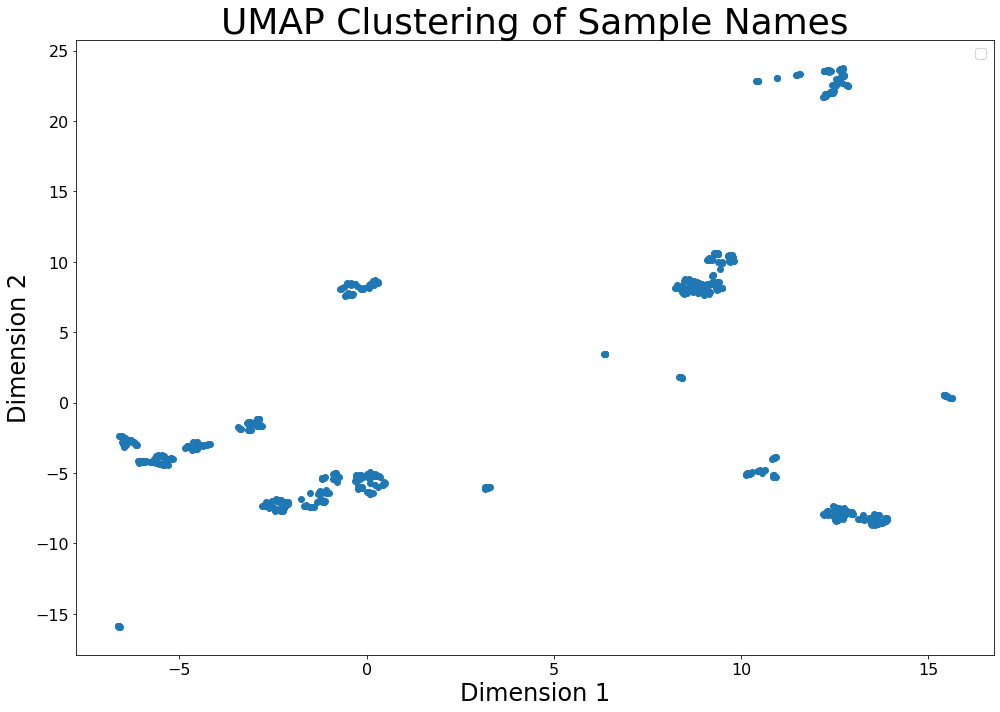

In [113]:
# n_components = 2

# # # Apply MDS to project the sample names into a lower-dimensional space
# # mds = MDS(n_components=n_components)
# # mds_embedding = mds.fit_transform(dist_mat)

# # Apply UMAP to project the sample names into a lower-dimensional space
# umap_model = UMAP(n_components=n_components, metric='precomputed')
# umap_embedding = umap_model.fit_transform(dist_mat)

# fig, ax = plt.subplots()
# ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1])
# ax.set_title("UMAP Clustering of Sample Names")
# ax.set_xlabel("Dimension 1")
# ax.set_ylabel("Dimension 2")

# ax.legend()

# fix_plot_visuals(fig)
# fig.show()

In [226]:
# import hdbscan

# labels = hdbscan.HDBSCAN(
#     min_samples=10,
#     min_cluster_size=500,
# ).fit_predict(clusterable_embedding)

ModuleNotFoundError: No module named 'hdbscan'